In [ ]:
# Mount Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Libraries

import os
import shutil
import torch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
np.random.seed(0)

In [ ]:
# Dataset Preparation

#mean = (0.5070751592371323, 0.48654887331495095, 0.4409178433670343)
#std = (0.2673342858792401, 0.2564384629170883, 0.27615047132568404)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    #transforms.Normalize(mean, std)
])

#train_dataset = datasets.CIFAR10('../data', train=True, download=True,
#                   transform=transform_train)

full_train = datasets.CIFAR10('../data', train=True, download=True,
                   transform=transform_train)

val_size = int(0.1 * len(full_train))                                             # 10% validation
train_size = len(full_train) - val_size

train_dataset, val_dataset = random_split(
    full_train, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

test_dataset = datasets.CIFAR10('../data', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.RandomCrop(32, padding=4),
                       transforms.ToTensor(),
                       #transforms.Normalize(mean, std)
                   ]))

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size=1024, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=1024, shuffle=False)

print("Train size:", len(train_dataset))
print("Validation size:", len(val_dataset))
print("Test size:", len(test_dataset))


# Save train, test and val image paths and labels in csv files

def save_split_to_csv(split_dataset, filename):
    if isinstance(split_dataset, torch.utils.data.Subset):
      indices = split_dataset.indices
      original_dataset = split_dataset.dataset
      samples = [(original_dataset.data[i],
                  original_dataset.targets[i]) for i in indices]
    else:
      samples = [(split_dataset.data[i],
                  split_dataset.targets[i]) for i in range(len(split_dataset))]
    df = pd.DataFrame(samples, columns=['image_path', 'label'])
    df.to_csv(filename, index=False)

# Save each split

save_split_to_csv(train_dataset, "/content/train_dataset.csv")
save_split_to_csv(val_dataset, "/content/val_dataset.csv")
save_split_to_csv(test_dataset, "/content/test_dataset.csv")

100%|██████████| 170M/170M [00:03<00:00, 43.6MB/s]


Train size: 45000
Validation size: 5000
Test size: 10000


### Train the ResNet18 Model with Adam

In [ ]:
train_losses = []
val_losses = []
test_losses = []

train_accuracies = []
val_accuracies = []
test_accuracies = []

criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1, reduction='sum')

def train(model, device, train_loader, optimizer):
    model.train()

    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        #output = torch.nn.functional.log_softmax(output, dim=1)
        loss = criterion(output, target) #torch.nn.functional.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

    avg_loss = running_loss / total
    accuracy = 100. * correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

    return avg_loss, accuracy

def test(model, device, test_loader, epoch):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            #output = torch.nn.functional.log_softmax(output, dim=1)
            test_loss = criterion(output, target)

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

            running_loss += test_loss.item()
            total += target.size(0)

    avg_loss = running_loss / total
    accuracy = 100. * correct / total
    test_losses.append(avg_loss)
    test_accuracies.append(accuracy)

    print('\nTest set epoch {}: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        epoch, avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return avg_loss, accuracy

def validate(model, device, val_loader, epoch):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            #output = torch.nn.functional.log_softmax(output, dim=1)
            #loss = torch.nn.functional.nll_loss(output, target, reduction='sum').item()
            val_loss = criterion(output, target)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

            running_loss += val_loss.item()
            total += target.size(0)

    avg_loss = running_loss / total
    accuracy = 100. * correct / total
    val_losses.append(avg_loss)
    val_accuracies.append(accuracy)

    print('\nValidation set epoch {}: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        epoch, avg_loss, correct, total, accuracy))

    return avg_loss, accuracy

In [ ]:
# Early stopping

class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, current_score):
        if self.best_score is None or current_score > self.best_score + self.min_delta:
            self.best_score = current_score
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [ ]:
from torchvision.models import ResNet18_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#model = models.resnet18(weights=None)
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)


model.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1,
                              padding=1, bias=False)                              # Modify the first convolutional layer for 32x32 input

model.maxpool = torch.nn.Identity()                                               # Modify or remove the initial max pooling layer
num_ftrs = model.fc.in_features                                                   # Modify the final fully connected layer for 100 classes

model.fc = torch.nn.Sequential(
    torch.nn.Dropout(p=0.5),
    torch.nn.Linear(num_ftrs, 10) # 10 classes in CIFAR10 dataset
)

model = model.to(device)

#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max',  factor=0.1, patience=7, verbose=True
)

early_stopping = EarlyStopping(patience=15, min_delta=0.0)

for i in range(1,150):
    train_loss, train_acc = train(model, device, train_loader, optimizer)
    val_loss, val_acc = validate(model, device, val_loader, i)
    test_loss, test_acc = test(model, device, test_loader, i)

    scheduler.step(val_acc)

    early_stopping(val_acc)
    if early_stopping.early_stop:
        print("Early stopping triggered. Training stopped.")
        break

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 190MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Validation set epoch 1: Average loss: 1.1644, Accuracy: 3539/5000 (71%)


Test set epoch 1: Average loss: 1.1234, Accuracy: 7334/10000 (73%)


Validation set epoch 2: Average loss: 1.0515, Accuracy: 3774/5000 (75%)


Test set epoch 2: Average loss: 0.9839, Accuracy: 7946/10000 (79%)


Validation set epoch 3: Average loss: 1.0211, Accuracy: 3877/5000 (78%)


Test set epoch 3: Average loss: 0.9638, Accuracy: 8034/10000 (80%)


Validation set epoch 4: Average loss: 0.9384, Accuracy: 4035/5000 (81%)


Test set epoch 4: Average loss: 0.8807, Accuracy: 8391/10000 (84%)


Validation set epoch 5: Average loss: 0.9066, Accuracy: 4143/5000 (83%)


Test set epoch 5: Average loss: 0.8336, Accuracy: 8603/10000 (86%)


Validation set epoch 6: Average loss: 0.8768, Accuracy: 4185/5000 (84%)


Test set epoch 6: Average loss: 0.8232, Accuracy: 8629/10000 (86%)


Validation set epoch 7: Average loss: 0.8346, Accuracy: 4288/5000 (86%)


Test set epoch 7: Average loss: 0.7944, Accuracy: 8777/10000 (88%)


In [ ]:
# Model summary
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

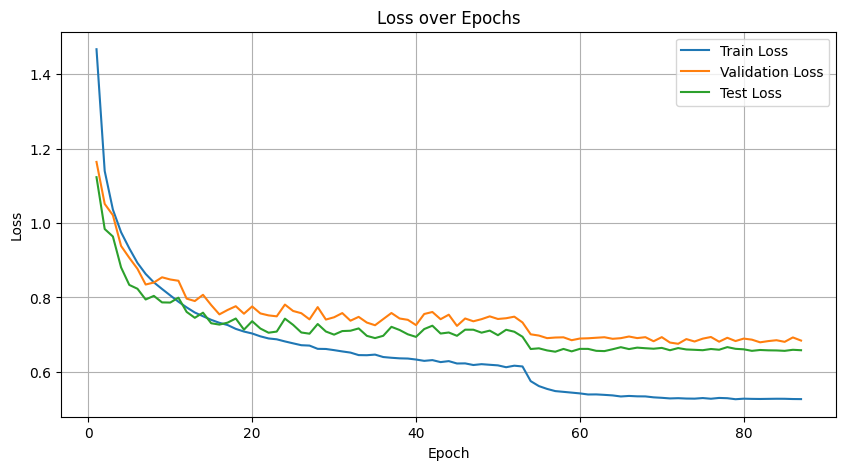

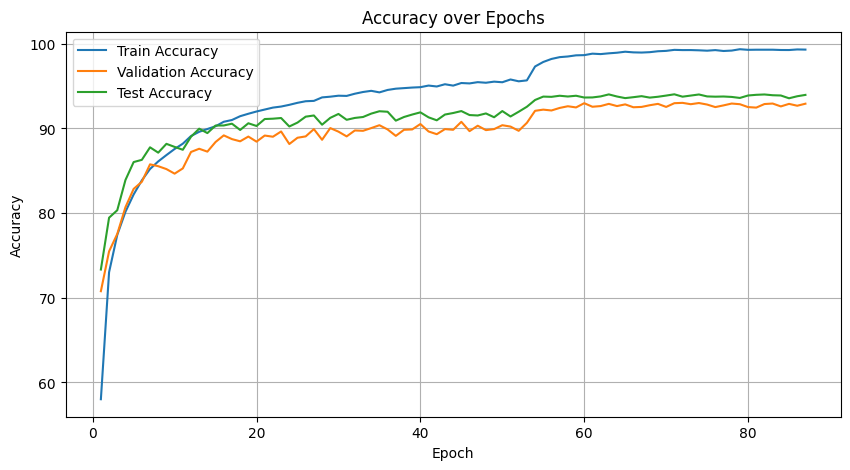

In [ ]:
# Visualize the training, validation process

max_epochs = 87
epochs = range(1, max_epochs+1)

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses[:max_epochs], label='Train Loss')
plt.plot(epochs, val_losses[:max_epochs], label='Validation Loss')
plt.plot(epochs, test_losses[:max_epochs], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies[:max_epochs], label='Train Accuracy')
plt.plot(epochs, val_accuracies[:max_epochs], label='Validation Accuracy')
plt.plot(epochs, test_accuracies[:max_epochs], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Save model
torch.save(model.state_dict(), '/Model/ResNet_model_weights_with_Adam.pth')

### Testing Model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loaded_model = models.resnet18(weights=None)

loaded_model.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
loaded_model.maxpool = torch.nn.Identity()
num_ftrs = loaded_model.fc.in_features
loaded_model.fc = torch.nn.Sequential(
    torch.nn.Dropout(p=0.5), #
    torch.nn.Linear(num_ftrs, 10)
)

# Load the saved state dictionary into the model
model_path = '/Model/ResNet_model_weights_with_Adam.pth'
loaded_model.load_state_dict(torch.load(model_path))
loaded_model = loaded_model.to(device)
loaded_model.eval()

test_loss, test_acc = test(loaded_model, device, test_loader, epoch=1)

print(f'\nAccuracy of the loaded model on the test dataset: {test_acc:.2f}%')


Test set epoch 1: Average loss: 0.6612, Accuracy: 9383/10000 (94%)


Accuracy of the loaded model on the test dataset: 93.83%
